# Gaussianization Flows (Details)

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse


KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [3]:
import pytorch_lightning as pl
from torchvision.datasets import MNIST

from torchvision import transforms
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from rbig_jax.data import GenericDataset

In [8]:
from rbig_jax.custom_types import ImageShape
from rbig_jax.transforms.reshape import flatten_image, unflatten_image
from typing import Optional

image_shape = ImageShape(C=1, H=28, W=28)


class MNISTDataModule(pl.LightningDataModule):
    def __init__(
        self,
        batch_size: int = 128,
        val_split: float = 0.2,
        seed: int = 123,
        flatten: bool = True,
        subset: Optional[int] = None,
    ):

        self.val_split = val_split
        self.batch_size = batch_size
        self.seed = seed
        self.flatten = flatten
        self.image_shape = ImageShape(C=1, H=28, W=28)
        self.subset = subset

    def prepare_data(self):
        # download
        self.train_dataset = MNIST(os.getcwd(), download=True, train=True)

    #         self.test_dataset = MNIST(os.getcwd(), download=True, train=False)

    def setup(self, stage=None):

        # assign train/val split
        Xtrain, Xval = train_test_split(
            self.train_dataset.data, test_size=self.val_split, random_state=self.seed,
        )

        Xtrain = Xtrain.numpy().astype(np.float32)[..., None]
        Xval = Xval.numpy().astype(np.float32)[..., None]

        if self.subset is not None:
            Xtrain = Xtrain[: self.subset]

        if self.flatten:
            Xtrain = flatten_image(Xtrain, self.image_shape, batch=True)
            Xval = flatten_image(Xval, self.image_shape, batch=True)

        self.Xtrain = Xtrain
        self.Xval = Xval
        self.ds_train = GenericDataset(Xtrain)
        self.ds_val = GenericDataset(Xval)

    def train_dataloader(self):
        return DataLoader(
            self.ds_train, batch_size=self.batch_size, shuffle=True, num_workers=0
        )

    def valid_dataloader(self):
        return DataLoader(
            self.ds_val, batch_size=self.batch_size, shuffle=False, num_workers=0
        )

In [9]:
# initialize loader
mnist_module = MNISTDataModule(subset=5_000)

# prepare and setup
mnist_module.prepare_data()
mnist_module.setup()

In [10]:
train_dl = mnist_module.train_dataloader()
valid_dl = mnist_module.valid_dataloader()

In [12]:
X = mnist_module.Xtrain


rng = np.random.RandomState(123)

# naive dequantization
X += rng.rand(*X.shape)

# scale data
X_train = X / 256.0

# subset
data = X_train

data.shape

(5000, 784)

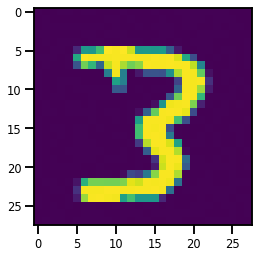

In [13]:
plt.imshow(unflatten_image(data[0], mnist_module.image_shape))

### Image Shape

(<Figure size 1000x1000 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f22b9f59ee0>)

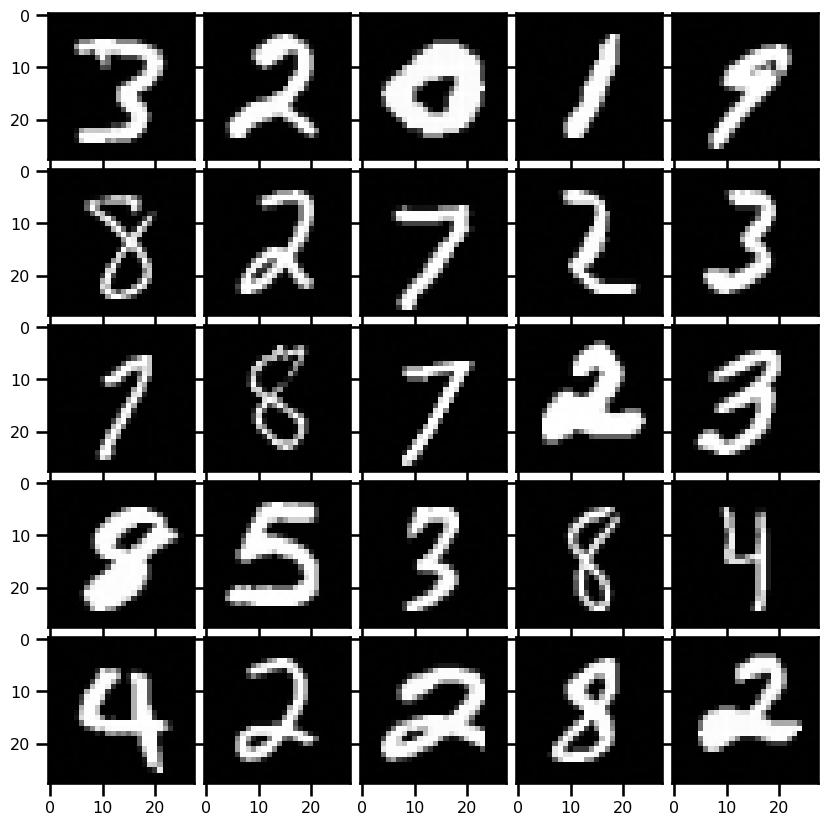

In [14]:
from rbig_jax.plots import plot_image_grid

plot_image_grid(data, mnist_module.image_shape)

## Model Inputs

In [15]:
from rbig_jax.transforms.reshape import flatten_image, unflatten_image

In [16]:
# X = flatten_image(data, image_shape, batch=True)
X = jnp.array(X[:10_000], dtype=jnp.float64)
X.shape

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2892: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")


(5000, 784)

(<Figure size 1000x1000 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f2269ac2910>)

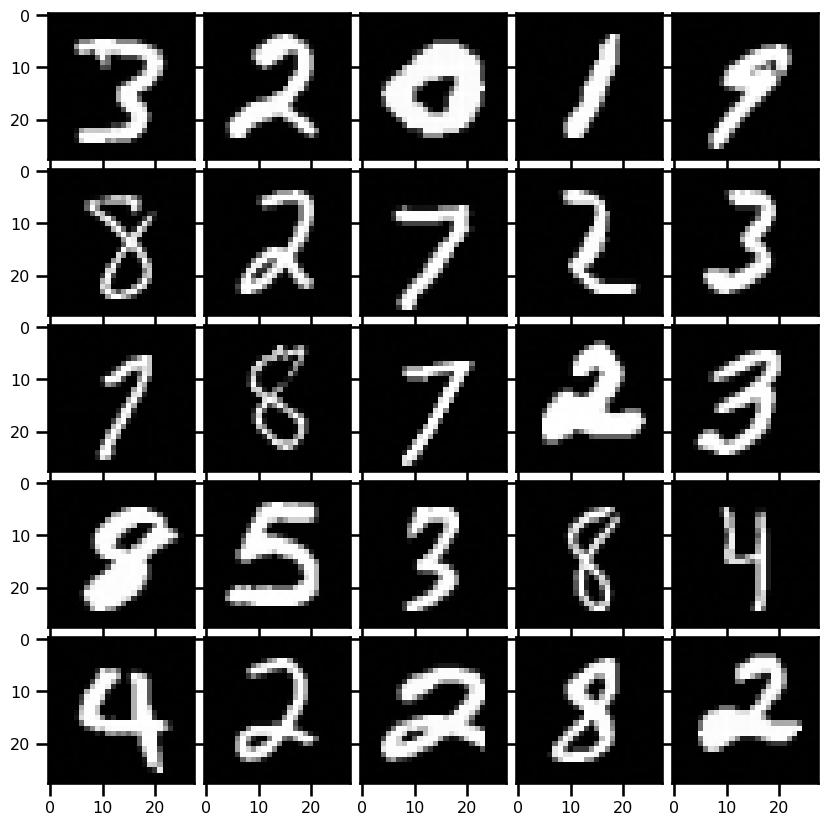

In [17]:
plot_image_grid(X, image_shape)

## Model - Naive

In [18]:
from rbig_jax.models.gaussflow import init_default_gf_model

In [19]:
n_blocks = 10
n_reflections = X.shape[1] // 2 + 1
mixture = "gaussian"
inverse_cdf = "gaussian"
init_mixcdf = "random"
init_rotation = "random"
plot_layers = False
plot_blocks = False
X_init = np.array(X[:5_000])

# init model
gf_model = init_default_gf_model(
    shape=X.shape[1:],
    X=X_init,
    n_blocks=n_blocks,
    init_mixcdf=init_mixcdf,
    init_rotation=init_rotation,
    inverse_cdf=inverse_cdf,
    mixture=mixture,
    n_reflections=n_reflections,
    plot_layers=plot_layers,
)

Initializing - Block: 10 | Layer 29: 100%|██████████| 10/10 [00:35<00:00,  3.51s/it]


In [20]:
%%time

X_g = gf_model.forward(X)

CPU times: user 2min 37s, sys: 57.4 s, total: 3min 34s
Wall time: 33.1 s


In [21]:
X_g.shape, X_g.min(), X_g.max()

((5000, 784),
 DeviceArray(-3.317936, dtype=float32),
 DeviceArray(3.472603, dtype=float32))

(<Figure size 1000x1000 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f21d467ecd0>)

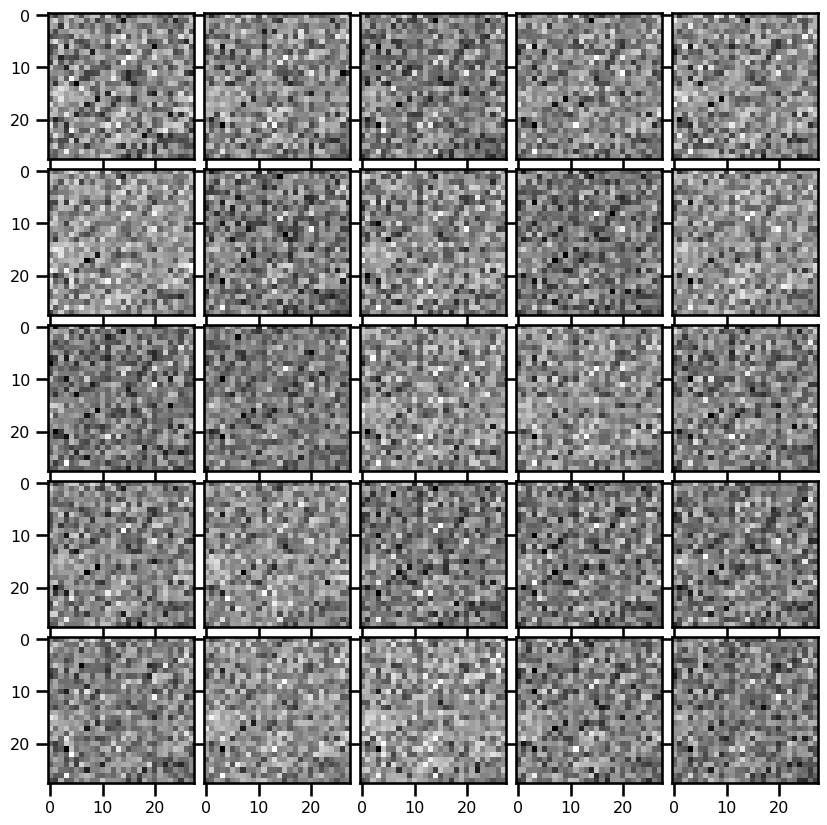

In [22]:
# plot data
plot_image_grid(X_g, image_shape)

#### Training

In [76]:
from jax.experimental import optimizers
from rbig_jax.training.parametric import init_train_op, init_gf_train_op, train_model


# lr = 0.05
lr = 5e-3
optimizer = optimizers.adam(step_size=lr)
jitted = True
# epochs = 150
epochs = 100

# train model
final_bijector, losses = train_model(
    gf_model,
    train_dl=train_dl,
    valid_dl=valid_dl,
    epochs=epochs,
    optimizer=optimizer,
    jitted=jitted,
)

  0%|          | 0/100 [17:08<?, ?it/s]


KeyboardInterrupt: 

### Results

#### Losses

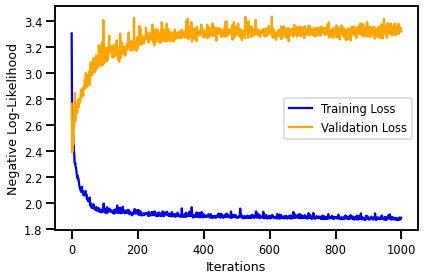

In [24]:
fig, ax = plt.subplots()
ax.plot(losses["train"], label="Training Loss", color="blue")
ax.plot(losses["valid"], label="Validation Loss", color="orange")
ax.set(xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.legend()
plt.tight_layout()
plt.show()

#### Latent Space

CPU times: user 1.77 s, sys: 25.6 ms, total: 1.8 s
Wall time: 1.72 s


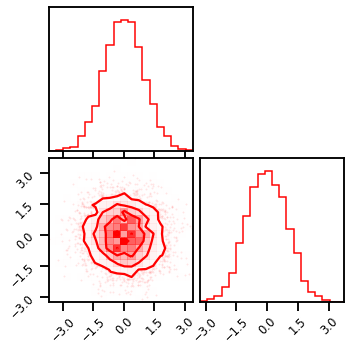

In [25]:
%%time
X_trans = final_bijector.forward(data)

fig = corner.corner(X_trans, color="Red")

#### Inverse Transform

CPU times: user 49.7 s, sys: 2.13 s, total: 51.9 s
Wall time: 18 s


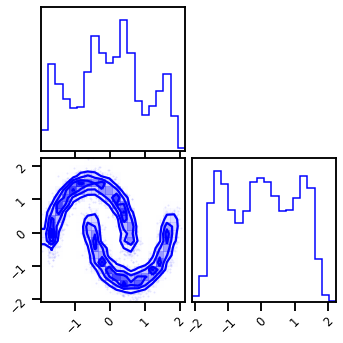

In [26]:
%%time

X_approx = final_bijector.inverse(X_trans)

fig = corner.corner(X_approx, color="Blue")

### Log Probability

In [27]:
%%time

from rbig_jax.data import generate_2d_grid

# general grid points
xyinput = generate_2d_grid(X, 500, buffer=0.2)

# calculate log probability
X_log_prob = final_bijector.score_samples(xyinput)

CPU times: user 6.03 s, sys: 1.95 s, total: 7.98 s
Wall time: 3.35 s


#### Plot: Original Density

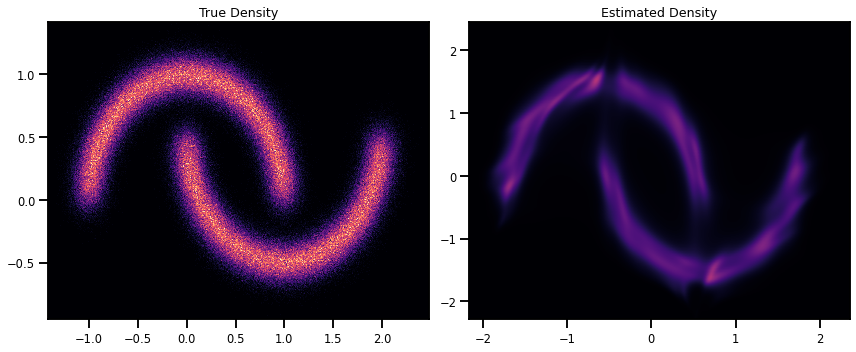

In [28]:
# # Original Density
# n_samples = 1_000_000
# n_features = 2
# X_plot = get_classic(n_samples, seed=123)
# X_plot = scaler.transform(X_plot)

# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)

h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
# plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()

### Sampling

In [ ]:
%%time
n_gen_samples = 100_000
X_samples = final_bijector.sample(seed=123, n_samples=n_gen_samples)

In [ ]:
# %%time
# # generate samples in the latent domain
# n_gen_samples = 10_000

# X_g_samples = Normal(0.0, 1.0).sample(seed=123, sample_shape=(n_gen_samples, 2))

# X_samples = final_bijector.inverse(X_g_samples)

# X_samples = np.array(gf_model.inverse(X_g_samples.block_until_ready()))

# # inverse transformation
# f = jax.jit(gf_model.inverse)
# X_samples = np.array(f(X_g_samples))

# # This way works too! But slower
# # generate samples in the latent domain
# n_gen_samples = 10_000

# # # inverse transformation
# X_samples = final_bijector.sample(seed=123, n_samples=n_gen_samples)

In [ ]:
fig = corner.corner(X, color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Each Layer

#### Original

In [ ]:
X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(gf_model.bijectors):
    
    X_g = ibijector.forward(X_g)
    
    if (ilayer+1) % 3 == 0:
        fig = corner.corner(X_g, color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()
        
    

#### Trained Model

In [ ]:

X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(final_bijector.bijectors):
    
    X_g = ibijector.forward(X_g)
    
    if (ilayer+1) % 3 == 0:
        fig = corner.corner(X_g, color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()
        
    
    

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_g[:, 0], X_g[:, 1], s=3)
ax.set_aspect('equal', 'box')
plt.tight_layout()

## Saving/Loading Model

In [ ]:
import pickle

#### Save Model

In [ ]:
with open("rbig_model.pickle", "wb") as f:
    pickle.dump(final_bijector, f)

#### Load Model

In [ ]:
with open("rbig_model.pickle", "rb") as f:
    rbig_model_ = pickle.load(f)